# Comparing Vegas generated without scanning with the KDE prediction in observables

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from parameters_dict import physics_parameters
from exp_analysis_class import exp_analysis
from plot_utils import *

## Get objects for all 4 cases 

we would like to compare them

notation = my_exp_analysis_{h for heavy, l for light}{d for dirac, m for majora}

In [3]:
hierarchy = 'heavy'
D_or_M = 'dirac'
save_folder = (f'../fig/3_comparison_observables/{hierarchy}_{D_or_M}/')
!mkdir -p $save_folder
my_exp_analysis_hd = exp_analysis(hierarchy, D_or_M)
my_exp_analysis_hd.load_df_base(1000000)


In [4]:
hierarchy = 'heavy'
D_or_M = 'majorana'
save_folder = (f'../fig/3_comparison_observables/{hierarchy}_{D_or_M}/')
!mkdir -p $save_folder
my_exp_analysis_hm = exp_analysis(hierarchy, D_or_M)
my_exp_analysis_hm.load_df_base(1000000)

In [5]:
hierarchy = 'light'
D_or_M = 'dirac'
save_folder = (f'../fig/3_comparison_observables/{hierarchy}_{D_or_M}/')
!mkdir -p $save_folder
my_exp_analysis_ld = exp_analysis(hierarchy, D_or_M)
my_exp_analysis_ld.load_df_base(1000000)

In [6]:
hierarchy = 'light'
D_or_M = 'majorana'
save_folder = (f'../fig/3_comparison_observables/{hierarchy}_{D_or_M}/')
!mkdir -p $save_folder
my_exp_analysis_lm = exp_analysis(hierarchy, D_or_M)
my_exp_analysis_lm.load_df_base(1000000)

In [7]:
# load all dfs
my_exp_analysis_hd.load_grid_dfs()
my_exp_analysis_hm.load_grid_dfs()
my_exp_analysis_ld.load_grid_dfs()
my_exp_analysis_lm.load_grid_dfs()

## Example of plotting comparisons for a single observable -- ee energy

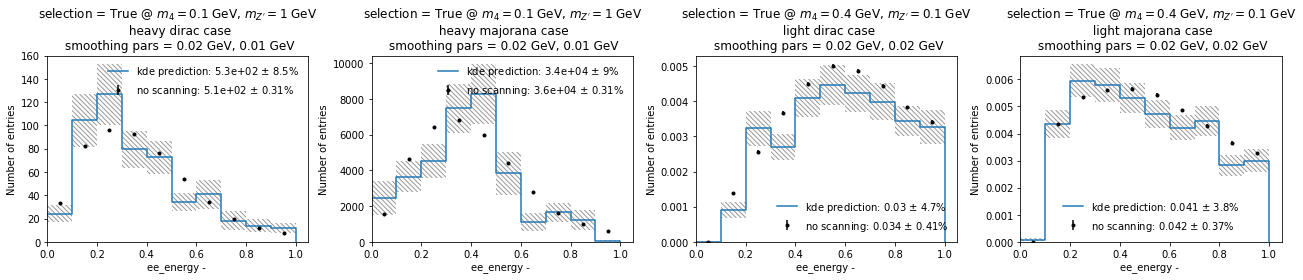

In [16]:
bins = 10
var1='ee_energy'
var2=''
varmin=0; varmax=1.0
fig,  axes = plt.subplots(nrows=1, ncols=4,figsize = (18,4))

# Heavy
m4mz = (0.1, 1)
smooth=(0.02,0.01)
exp_analyses=[my_exp_analysis_hd,my_exp_analysis_hm]
batch_comparison_plot(axes[:2],exp_analyses, m4mz,var1,var2,smooth=smooth,var_range=(varmin,varmax), bins=bins)

# light
m4mz = (0.4, 0.1)
smooth=(0.02,0.02)
exp_analyses=[my_exp_analysis_ld,my_exp_analysis_lm]
batch_comparison_plot(axes[2:],exp_analyses, m4mz,var1,var2,smooth=smooth,var_range=(varmin,varmax), bins=bins)

plt.tight_layout()

## Comparing (heavy light)(maj dir) for all variables 

plots stored in multi-page pdf in plots/generation_KDE_comparisons/

In [67]:
%%capture
m4mzheavy= (0.1, 1)
m4mzlight = (0.4, 0.03)

# cases for each panel
exp_analyses=[my_exp_analysis_hd,my_exp_analysis_hm,my_exp_analysis_ld,my_exp_analysis_lm]

batch_comparison_light_heavy(f"../plots/generation_KDE_comparisons/m4H_{m4mzheavy[0]}_mzH_{m4mzheavy[1]}_m4L_{m4mzlight[0]}_mzL_{m4mzlight[1]}.pdf", 
                           exp_analyses,m4mzheavy,m4mzlight)

In [27]:
%%capture
m4mzheavy= (0.01, 1)
m4mzlight = (0.4, 0.03)

s# cases for each panel
exp_analyses=[my_exp_analysis_hd,my_exp_analysis_hm,my_exp_analysis_ld,my_exp_analysis_lm]

batch_comparison_light_heavy(f"../plots/generation_KDE_comparisons/m4H_{m4mzheavy[0]}_mzH_{m4mzheavy[1]}_m4L_{m4mzlight[0]}_mzL_{m4mzlight[1]}.pdf", 
                           exp_analyses,m4mzheavy,m4mzlight)

## Compare different cut stages for a single (heavy light)(maj dir) case

In [65]:
%%capture
m4mz= (0.1, 0.03)

exp_analyses=[my_exp_analysis_lm]*4
# varying var range for light case -- standard def is better for heavy case
var_range = [(0,1.0),
            (0,np.pi/4),
            (0,m4mz[0]),
            (-1,1.0),
            (0,np.pi/4),
            (0,np.pi/4),
            (0,0.01)]
smooth_light=(0.02,0.02)
batch_comparison_cutlevels(f"../plots/generation_KDE_comparisons/cut_flow_m4_{m4mz[0]}_mz_{m4mz[1]}.pdf", 
                           exp_analyses, m4mz, smooth = smooth_light,
                           var_range=var_range,
                           sel_criterion=['no_cuts', 'cut1', 'cut2', 'cut_based'])  

In [66]:
%%capture
m4mz= (0.1, 1)
exp_analyses=[my_exp_analysis_hm]*4

batch_comparison_cutlevels(f"../plots/generation_KDE_comparisons/cut_flow_m4_{m4mz[0]}_mz_{m4mz[1]}.pdf", 
                           exp_analyses, m4mz, sel_criterion=['no_cuts', 'cut1', 'cut2', 'cut_based'])

# This is all pretty old stuff

## Test comparison between KDE and truth

In [ ]:
case = 'light'
pars = {}
pars['heavy'] = {
    'm4' : [0.1, 0.2, 0.3, 0.4],
    'mz_prime': [1.25],
}
pars['light'] = {
    'm4' : [0.2, 0.3, 0.4], 
    'mz_prime': [0.03, 0.045, 0.06],
}

ctaus = [1, 5, 10, 20, 50, 100, 200]
!mkdir -p ../../fig/kde_test_2d/comparison_kde_truth/
save_folder = "../../fig/kde_test_2d/comparison_kde_truth/"
produce_samples = False

#generation part
if produce_samples:
    for m4, mz_prime in itertools.product(pars[case]['m4'], pars[case]['mz_prime']):
        print(m4, mz_prime)
        if case == 'light':
            dark_gen_run = f'cd ..; ./dark_gen.py --M4 {m4} --mzprime {mz_prime} --UMU4 8e-9 --alpha_dark 0.25 --alpha_epsilon2 2e-10 --hierarchy light_mediator --neval 100000 --noplot'
        elif case == 'heavy':
            dark_gen_run = f'cd ..; ./dark_gen.py --M4 {m4} --mzprime {mz_prime} --UMU4 2.2e-7 --alpha_dark 0.4 --epsilon2 4.6e-4 --neval 100000 --noplot --hierarchy heavy_mediator'
        else:
            print('No good case selected')
        stream = os.popen(dark_gen_run)
        print(stream.read())

In [ ]:
# 1d histograms with one specific variable
var_1 = 'ee_energy'
var_2 = ''
hist_range = [0, 5]
bins = 20
ctau = 1
smooth_m4 = 0.03
smooth_mz = 0.005

kde_total = dict(zip(['no_selection', 'cut_based'], [[], []]))
truth_total = dict(zip(['no_selection', 'cut_based'], [[], []]))

for m4, mz in itertools.product(pars[case]['m4'], pars[case]['mz_prime']):
    df = pd.read_pickle(f'../data/nd280_nu/3plus1/m4_{m4}_mzprime_{mz}/MC_m4_{m4}_mzprime_{mz}.pckl')
    initialise_df(df)
    for selection_step in ['no_selection', 'cut_based']:

        aux_out = output_distrib(df_base, var_1, var_2, bins, hist_range, m4, mz, ctau, smooth_m4, smooth_mz, selection_step)
        kde_total[selection_step].append(aux_out)

        truth_weights = df['actual_weight', '']*df[selection_step, '']
        plt.hist(df[var_1, var_2],
             range=hist_range,
             bins=bins,
             weights=truth_weights,
             histtype='step',
             label=f'truth with $m_4$ = {m4:.2g} GeV, $m_Z$ = {mz:.2g} GeV\nexpected events = {truth_weights.sum():.1f}')
        truth_total[selection_step].append(truth_weights.sum())
        plt.autoscale()
        plt.legend(frameon=False)
        plt.savefig(save_folder+f"case_{case}_m4_{m4}_mz_{mz}_N_{n_evt}_{selection_step}.png", bbox_inches='tight', dpi=250)
        plt.close()

In [ ]:
# 2d ratio of kde and truth
smooth_m4 = 0.03
smooth_mz = 0.005
ctau = 10

kde_total = dict(zip(['no_selection', 'cut_based'], [[], []]))
truth_total = dict(zip(['no_selection', 'cut_based'], [[], []]))
likes_kde = dict(zip(['no_selection', 'cut_based'], [[], []]))
likes_truth = dict(zip(['no_selection', 'cut_based'], [[], []]))
ratios = dict(zip(['no_selection', 'cut_based'], [[], []]))
sigma_ratios = dict(zip(['no_selection', 'cut_based'], [[], []]))

for m4, mz in itertools.product(pars[case]['m4'], pars[case]['mz_prime']):
    df = pd.read_pickle(f'../data/nd280_nu/3plus1/m4_{m4}_mzprime_{mz}/MC_m4_{m4}_mzprime_{mz}.pckl')
    initialise_df(df)
    for selection_step in ['no_selection', 'cut_based']:
        mu_kde, sigma2_kde = mu_sigma2_of_theta(df_base, m4, mz, ctau, smooth_m4, smooth_mz, selection_step)
        kde_total[selection_step].append(mu_kde)
        likes_kde[selection_step].append(LEff(0, mu_kde, sigma2_kde))

        mu_truth = (df['actual_weight', '']*df[selection_step, '']).sum()
        sigma2_truth = ((df['actual_weight', '']*df[selection_step, ''])**2).sum()
        truth_total[selection_step].append(mu_truth)
        likes_truth[selection_step].append(LEff(0, mu_truth, sigma2_truth))

        ratio = mu_kde/mu_truth
        ratios[selection_step].append(ratio)
        
        sigma_ratio = ratio*np.sqrt(sigma2_kde/(mu_kde**2) + sigma2_truth/(mu_truth**2))
        sigma_ratios[selection_step].append(sigma_ratio)
        print(selection_step)
        print(f"m4 = {m4}, mz = {mz}, kde = {mu_kde:.2g}, truth = {mu_truth:.2g}, ratio = {ratio:.2g} +/- {sigma_ratio:.2g}")
        print(f"relative sigma_kde = {np.sqrt(sigma2_kde)/mu_kde:.2g}, sigma_truth = {np.sqrt(sigma2_truth)/mu_truth:.2g}")

In [ ]:
def create_bin_edges_from_array(ar):
    ar_min = 2* ar[0] - ar[1]
    ar_max = 2* ar[-1] - ar[-2]
    new_ar = np.array([ar_min] + list(ar) + [ar_max])
    return np.array((new_ar[1:] + new_ar[:-1])/2)

In [ ]:
m4_centres = np.array(pars[case]['m4'])
mz_centres = np.array(pars[case]['mz_prime'])
m4_edges = create_bin_edges_from_array(m4_centres)
mz_edges = create_bin_edges_from_array(mz_centres)

ratio_total = {}
for sel in kde_total.keys():
    this_ratio = np.array(ratios[sel]).reshape(len(pars[case]['m4']), len(pars[case]['mz_prime']))
    this_sigma_ratio = np.array(sigma_ratios[sel]).reshape(len(pars[case]['m4']), len(pars[case]['mz_prime']))
    plt.pcolormesh(m4_edges, mz_edges, this_ratio.T)
    for i in range(len(m4_centres)):
        for j in range(len(mz_centres)):
            text = plt.text(pars[case]['m4'][j], pars[case]['mz_prime'][i], f"{this_ratio[j, i]:.3g} $\pm$ {this_sigma_ratio[j, i]:.1g}",
                            ha="center", va="center", color="k")
    plt.colorbar()
    plt.xlabel(r'$m_4$ [GeV]')
    plt.ylabel(r'$m_Z$ [GeV]')
    plt.title(f'KDE estimate/truth ratio at {sel}')
    plt.savefig(save_folder+f"kde_truth_ratio_2d_summary_case_{case}_N_{n_evt}_{sel}.png", bbox_inches='tight', dpi=250)
    plt.close()

In [ ]:
m4_centres = np.array(pars[case]['m4'])
mz_centres = np.array(pars[case]['mz_prime'])
m4_edges = create_bin_edges_from_array(m4_centres)
mz_edges = create_bin_edges_from_array(mz_centres)

likes = dict(zip(['kde', 'truth'], [likes_kde, likes_truth]))
for sel in kde_total.keys():
    for mode in ['kde', 'truth']:
        this_like = -1*np.array(likes[mode][sel]).reshape(len(pars[case]['m4']), len(pars[case]['mz_prime']))
        this_like -= this_like.min()
        plt.pcolormesh(m4_edges, mz_edges, this_like.T)
        for i in range(len(m4_centres)):
            for j in range(len(mz_centres)):
                text = plt.text(pars[case]['m4'][j], pars[case]['mz_prime'][i], f"{this_like[j, i]:.3g}",
                                ha="center", va="center", color="k")
        plt.colorbar()
        plt.xlabel(r'$m_4$ [GeV]')
        plt.ylabel(r'$m_Z$ [GeV]')
        plt.title(f'Effective likelihood of seeing 0 events\nestimated with {mode} at {sel}')
        plt.savefig(save_folder+f"likelihood_profile_{mode}_case_{case}_N_{n_evt}_{sel}.png", bbox_inches='tight', dpi=250)
        plt.close()